In [1]:
import pandas as pd
import regex as re
import numpy as np

import torch
from sklearn.model_selection import train_test_split
from transformers import T5Tokenizer, T5ForConditionalGeneration, AutoTokenizer, MT5ForConditionalGeneration, get_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW, lr_scheduler

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
SEP_TOKEN = '▁<extra_id_0>'    #' ; '

In [3]:
df = pd.read_json ('train_t1_v1.jsonl', lines = True)
df.drop (columns = ['id', 'keywords'], inplace = True)
print (df.head ())

def split_text (text, segments, delimiters = ['...', '.', '?!', '?', '!']):

    # Фильтрация
    #text = re.sub ('[“”]', '\"', text)

    # Создаем регулярное выражение для разделителей
    delimiters_pattern = '|'.join (map (re.escape, delimiters))
    
    # Разделяем текст на абзацы
    paragraphs = re.split (f'(?<=\n[ ]*)', text)
    
    # Список для хранения предложений и их индексов
    sentences_with_segments = []
    
    current_start_index = 0
    # Обрабатываем каждый абзац
    for paragraph in paragraphs:
        # Разделяем абзац на предложения
        sentences = re.split (f'(?<=[{delimiters_pattern}] )(?=[A-ZА-ЯЁ])', paragraph)#.strip ())
        
        # Сопоставляем предложения с сегментами
        for sentence in sentences:
            # Ищем индексы символов для текущего предложения
            start_index = current_start_index
            end_index = start_index + len (sentence)

            matched_segments = [
                text [start: end] for start, end in segments if start >= start_index and end <= end_index
            ]
            sentences_with_segments.append ((sentence, matched_segments))

            current_start_index = end_index
    
    return sentences_with_segments


parallel_text = []
parallel_label = []
#for i, row in tqdm (df.iterrows (), total = df.shape [0], desc = "Processing texts: "):
for i, row in df.iterrows ():
    text = row ['text']
    segments = row ['label']
    splitted = split_text (text, segments)
    for sentence, terms in splitted:
        parallel_text.append (sentence)
        constructed_label = ''
        for term in terms:
            constructed_label += term.strip () + SEP_TOKEN
        if len (constructed_label) > 0:
            parallel_label.append (constructed_label [: - len (SEP_TOKEN)])
        else:
            parallel_label.append ('')

                                                text  \
0  ABBYY Retrieval & Morphology Engine\nВ сообщен...   
1  Речевые формулы в диалоге\nПредложенная класси...   
2  Географические названия и полнотекстовые докум...   
3  Методы автоматического построения специализиро...   
4  Закономерности построения дискурсивной последо...   

                                               label  
0  [[0, 35], [6, 15], [18, 35], [29, 35], [69, 88...  
1  [[0, 15], [18, 25], [74, 99], [134, 140], [175...  
2  [[0, 23], [26, 50], [54, 68], [169, 190], [181...  
3  [[7, 63], [34, 63], [54, 63], [92, 128], [119,...  
4  [[26, 57], [62, 76], [251, 265], [266, 280], [...  


In [ ]:
USED_MODEL_NAME = 'cointegrated/rut5-small'
#USED_MODEL_NAME = './coint_rut5small_finetune_5875'
#USED_MODEL_NAME = 'ai-forever/ruT5-base'
SEQ_MAX_LENGTH = 150
BATCH_SIZE = 2
EVAL_BATCH_SIZE = 2

In [5]:
#tokenizer = T5Tokenizer.from_pretrained (USED_MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained (USED_MODEL_NAME)
tokenizer

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
c:\Users\Enfi\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


T5TokenizerFast(name_or_path='cointegrated/rut5-small', vocab_size=20200, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', 

In [6]:
#tokenizer.add_special_tokens ({'additional_special_tokens': str (SEP_TOKEN)})
#tokenizer

In [7]:
enc = tokenizer (parallel_label [3], padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
enc


{'input_ids': tensor([[ 5269,  1531,  8484,  9304,   433, 20099,  6972, 17003,     1,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [8]:
tokenizer.batch_decode (enc ['input_ids'])

['Речевые формулы <extra_id_0> диалоге</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>']

In [9]:
train_data_txt, temp_data_txt, train_labels_txt, temp_labels_txt = train_test_split (parallel_text, parallel_label, test_size = 0.2, random_state = 14)
val_data_txt, test_data_txt, val_labels_txt, test_labels_txt = train_test_split (temp_data_txt, temp_labels_txt, test_size = 0.5, random_state = 14)

In [10]:
train_data = tokenizer (train_data_txt, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
train_labels = tokenizer (train_labels_txt, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')

val_data = tokenizer (val_data_txt, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
val_labels = tokenizer (val_labels_txt, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')

test_data = tokenizer (test_data_txt, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
test_labels = tokenizer (test_labels_txt, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')

In [11]:
class Seq2SeqDataset (Dataset):
    def __init__ (self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__ (self, idx):
        return {
            'input_ids': self.encodings ['input_ids'] [idx],
            'attention_mask': self.encodings ['attention_mask'] [idx],
            'labels': self.labels ['input_ids'] [idx]
        }

    def __len__ (self):
        return len (self.encodings ['input_ids'])

train_dataset = Seq2SeqDataset (train_data, train_labels)
val_dataset = Seq2SeqDataset (val_data, val_labels)
test_dataset = Seq2SeqDataset (test_data, test_labels)

train_loader = DataLoader (train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader (val_dataset, batch_size = EVAL_BATCH_SIZE)
test_loader = DataLoader (test_dataset, batch_size = EVAL_BATCH_SIZE)

In [12]:
device = torch.device ('cuda' if torch.cuda.is_available () else 'cpu')

model = MT5ForConditionalGeneration.from_pretrained (USED_MODEL_NAME)

model.to (device)
print (model.device)
#model.train ()


cuda:0


In [13]:
def get_set (tensor, ground_truth = True, tokenizer = tokenizer):

    separator: str
    if SEP_TOKEN == '▁<extra_id_0>': separator = '<extra_id_0>'
    else: separator = SEP_TOKEN

    res: set

    if ground_truth:
        eos_idx = (tensor == 1).nonzero ()
        if eos_idx.numel () > 0:
            eos_idx = int (eos_idx [0] [0])
        else:
            eos_idx = len (tensor)
        seq = tensor [:eos_idx]
    
    else:
        seq = tensor [tensor != 0]
        seq = seq [seq != 1]
    
    txt = tokenizer.decode (seq)
    res = set ([item.strip () for item in txt.split (separator)])

    if len (res) > 1:
        res -= set ([''])

    return res


def sanity_check (preds, labels, to_print = False):

    tps_sum = 0
    fps_sum = 0
    fns_sum = 0 

    for i in range (len (labels)):
        predicted_set = get_set (preds [i], ground_truth = False)
        true_set = get_set (labels [i])

        if to_print: print (f'True: {true_set}\nPred: {predicted_set}')

        tps_sum += len (true_set & predicted_set)  # Истинно положительные
        fps_sum += len (predicted_set - true_set)     # Ложноположительные
        fns_sum += len (true_set - predicted_set)     # Ложноотрицательные

    precision = tps_sum / (tps_sum + fps_sum) if (tps_sum + fps_sum) > 0 else 0
    recall = tps_sum / (tps_sum + fns_sum) if (tps_sum + fns_sum) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

In [14]:
metrics = {'train_loss': [], 'val_loss': [], 'precision': [], 'recall': [], 'f1_score': []}

In [15]:
for name, module in model.named_modules():
    print(name, module)
    print ('--------========--------')


 MT5ForConditionalGeneration(
  (shared): Embedding(20100, 512)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(20100, 512)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
           

In [16]:
for param in model.parameters ():
    param.requires_grad = True

In [17]:
def freeze_layers_by_type (model, layer_type = 'attention'):
    for name, param in model.named_parameters ():
        if layer_type in name:
            param.requires_grad = False
            print (f'Layer {name} frozen')
        else:
            print (f'Layer {name} trainable')

In [18]:
#freeze_layers_by_type (model, 'encoder')

In [19]:
num_epochs = 50
training_steps = len (train_data ['input_ids']) // BATCH_SIZE * num_epochs
print (f'Suggested train steps: {training_steps}\n\t warmup steps: {int (training_steps * 0.05)} - {int (training_steps * 0.1)}')

Suggested train steps: 41800
	 warmup steps: 2090 - 4180


In [20]:
#optimizer = AdamW (model.parameters (), lr = 1e-5)#, weight_decay = 0.05)
optimizer = AdamW (filter (lambda p: p.requires_grad, model.parameters ()), lr = 1e-4, weight_decay = 0.01)
#scheduler = lr_scheduler.StepLR (optimizer, warmup_steps = 637, training_steps = 6375)
scheduler = get_scheduler ('linear', optimizer = optimizer, num_warmup_steps = 4200, num_training_steps = 42000)

In [21]:
for epoch in range (num_epochs):
    model.train ()  # Устанавливаем модель в режим обучения
    total_loss = 0
    
    for batch in tqdm (train_loader):
        
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)

        outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels)
        loss = outputs.loss   ## DOUBLE CHECK if padding ...
        total_loss += loss.item ()

        loss.backward ()  # Обратное распространение
        optimizer.step ()  # Обновление параметров
        optimizer.zero_grad ()  # Обнуляем градиенты

        scheduler.step ()  # Обновление learning rate
    

    avg_loss = total_loss / len (train_loader)

    metrics ['train_loss'].append ((epoch, avg_loss))

    # Оценка на валидационной выборке
    model.eval ()  # Устанавливаем модель в режим оценки
    val_preds, val_labels = [], []
    total_val_loss = 0

    with torch.no_grad ():
        for batch in val_loader:
            input_ids = batch ['input_ids'].to (model.device)
            attention_mask = batch ['attention_mask'].to (model.device)
            labels = batch ['labels'].to (model.device)

            outputs = model.generate (input_ids = input_ids, attention_mask = attention_mask)

            total_val_loss += model (input_ids = input_ids, attention_mask = attention_mask, labels = labels).loss.item ()

            val_preds.extend (outputs)
            val_labels.extend (labels)

    avg_val_loss = total_val_loss / len (val_loader)

    prec, recl, f1sc = sanity_check (val_preds, val_labels)

    metrics ['val_loss'].append ((epoch, avg_val_loss))
    metrics ['precision'].append ((epoch, prec))
    metrics ['recall'].append ((epoch, recl))
    metrics ['f1_score'].append ((epoch, f1sc))

    print (f'Epoch {epoch + 1} / {num_epochs}, Loss: {avg_loss:.4f}, Validation loss: {avg_val_loss:.4f}, {prec} / {recl} / {f1sc}')

100%|██████████| 837/837 [01:05<00:00, 12.86it/s]


Epoch 1 / 50, Loss: 11.6608, Validation loss: 0.9010, 0.02631578947368421 / 0.005841741901221455 / 0.009561060408518035


100%|██████████| 837/837 [00:58<00:00, 14.29it/s]


Epoch 2 / 50, Loss: 0.5691, Validation loss: 0.1914, 0.288698955365622 / 0.1614445034519384 / 0.20708446866485014


100%|██████████| 837/837 [00:59<00:00, 14.14it/s]


Epoch 3 / 50, Loss: 0.2375, Validation loss: 0.1371, 0.4142732811140122 / 0.2527881040892193 / 0.3139841688654354


100%|██████████| 837/837 [01:10<00:00, 11.80it/s]


Epoch 4 / 50, Loss: 0.1739, Validation loss: 0.1064, 0.49162011173184356 / 0.3271375464684015 / 0.39285714285714285


100%|██████████| 837/837 [01:09<00:00, 12.05it/s]


Epoch 5 / 50, Loss: 0.1393, Validation loss: 0.0892, 0.5409961685823754 / 0.3749336165693043 / 0.44291091593475534


100%|██████████| 837/837 [01:10<00:00, 11.94it/s]


Epoch 6 / 50, Loss: 0.1164, Validation loss: 0.0828, 0.5635930047694754 / 0.37652681890600104 / 0.4514485832537409


100%|██████████| 837/837 [01:09<00:00, 12.09it/s]


Epoch 7 / 50, Loss: 0.0991, Validation loss: 0.0732, 0.5892179195140471 / 0.4121083377588954 / 0.48500000000000004


100%|██████████| 837/837 [01:09<00:00, 12.12it/s]


Epoch 8 / 50, Loss: 0.0876, Validation loss: 0.0701, 0.5944487278334618 / 0.4094530005310674 / 0.48490566037735844


100%|██████████| 837/837 [01:08<00:00, 12.16it/s]


Epoch 9 / 50, Loss: 0.0783, Validation loss: 0.0671, 0.6027293404094011 / 0.4221986192246415 / 0.49656464709556525


100%|██████████| 837/837 [01:08<00:00, 12.20it/s]


Epoch 10 / 50, Loss: 0.0700, Validation loss: 0.0613, 0.6440809968847352 / 0.4391927774827403 / 0.5222608146510893


100%|██████████| 837/837 [01:09<00:00, 12.06it/s]


Epoch 11 / 50, Loss: 0.0630, Validation loss: 0.0628, 0.6480314960629922 / 0.43706850770047795 / 0.5220424992071043


100%|██████████| 837/837 [01:07<00:00, 12.31it/s]


Epoch 12 / 50, Loss: 0.0580, Validation loss: 0.0621, 0.6237698713096139 / 0.43759957514604353 / 0.5143570536828964


100%|██████████| 837/837 [01:07<00:00, 12.44it/s]


Epoch 13 / 50, Loss: 0.0523, Validation loss: 0.0590, 0.6591614906832298 / 0.4508762612851832 / 0.5354777672658468


100%|██████████| 837/837 [01:07<00:00, 12.38it/s]


Epoch 14 / 50, Loss: 0.0479, Validation loss: 0.0586, 0.6529543754674645 / 0.4636218799787573 / 0.5422360248447204


100%|██████████| 837/837 [01:08<00:00, 12.25it/s]


Epoch 15 / 50, Loss: 0.0439, Validation loss: 0.0568, 0.683206106870229 / 0.4753053637812002 / 0.560601315377388


100%|██████████| 837/837 [01:07<00:00, 12.44it/s]


Epoch 16 / 50, Loss: 0.0404, Validation loss: 0.0577, 0.6739469578783152 / 0.45884227296866703 / 0.5459715639810426


100%|██████████| 837/837 [01:07<00:00, 12.36it/s]


Epoch 17 / 50, Loss: 0.0373, Validation loss: 0.0584, 0.6880308880308881 / 0.4731810939989379 / 0.5607300188797987


100%|██████████| 837/837 [01:07<00:00, 12.33it/s]


Epoch 18 / 50, Loss: 0.0350, Validation loss: 0.0604, 0.6761102603369066 / 0.4689325544344132 / 0.5537786139855754


100%|██████████| 837/837 [01:08<00:00, 12.16it/s]


Epoch 19 / 50, Loss: 0.0329, Validation loss: 0.0591, 0.6922480620155039 / 0.47424322889006904 / 0.5628742514970061


100%|██████████| 837/837 [01:07<00:00, 12.33it/s]


Epoch 20 / 50, Loss: 0.0304, Validation loss: 0.0605, 0.6773700305810397 / 0.4705257567711099 / 0.55531181447822


100%|██████████| 837/837 [01:07<00:00, 12.44it/s]


Epoch 21 / 50, Loss: 0.0277, Validation loss: 0.0645, 0.6814932486100079 / 0.4556558682952735 / 0.5461489497135582


100%|██████████| 837/837 [01:08<00:00, 12.18it/s]


Epoch 22 / 50, Loss: 0.0273, Validation loss: 0.0606, 0.6911196911196911 / 0.4753053637812002 / 0.5632473253618628


100%|██████████| 837/837 [01:08<00:00, 12.25it/s]


Epoch 23 / 50, Loss: 0.0247, Validation loss: 0.0633, 0.6829457364341085 / 0.467870419543282 / 0.5553104317680428


100%|██████████| 837/837 [01:10<00:00, 11.88it/s]


Epoch 24 / 50, Loss: 0.0232, Validation loss: 0.0617, 0.6853415195702226 / 0.47424322889006904 / 0.5605775266792216


100%|██████████| 837/837 [01:08<00:00, 12.22it/s]


Epoch 25 / 50, Loss: 0.0222, Validation loss: 0.0626, 0.708300395256917 / 0.4758364312267658 / 0.5692503176620075


100%|██████████| 837/837 [01:09<00:00, 12.05it/s]


Epoch 26 / 50, Loss: 0.0211, Validation loss: 0.0626, 0.6854103343465046 / 0.4790228359001593 / 0.5639262269459207


100%|██████████| 837/837 [01:09<00:00, 12.09it/s]


Epoch 27 / 50, Loss: 0.0200, Validation loss: 0.0637, 0.6965944272445821 / 0.47796070100902815 / 0.5669291338582677


100%|██████████| 837/837 [01:09<00:00, 12.07it/s]


Epoch 28 / 50, Loss: 0.0192, Validation loss: 0.0659, 0.7100545596258768 / 0.4838024429102496 / 0.5754895767530006


100%|██████████| 837/837 [01:08<00:00, 12.21it/s]


Epoch 29 / 50, Loss: 0.0179, Validation loss: 0.0659, 0.7015384615384616 / 0.4843335103558152 / 0.5730442978322338


100%|██████████| 837/837 [01:08<00:00, 12.15it/s]


Epoch 30 / 50, Loss: 0.0171, Validation loss: 0.0641, 0.7079169869331283 / 0.48911311736590546 / 0.5785175879396985


100%|██████████| 837/837 [01:09<00:00, 11.98it/s]


Epoch 31 / 50, Loss: 0.0163, Validation loss: 0.0672, 0.6852559205500381 / 0.4763674986723314 / 0.56203007518797


100%|██████████| 837/837 [01:08<00:00, 12.23it/s]


Epoch 32 / 50, Loss: 0.0162, Validation loss: 0.0676, 0.7240031274433151 / 0.4917684545937334 / 0.5857052498418722


100%|██████████| 837/837 [01:08<00:00, 12.29it/s]


Epoch 33 / 50, Loss: 0.0146, Validation loss: 0.0671, 0.7062015503875969 / 0.4838024429102496 / 0.5742199810904506


100%|██████████| 837/837 [01:07<00:00, 12.45it/s]


Epoch 34 / 50, Loss: 0.0145, Validation loss: 0.0694, 0.7149532710280374 / 0.4875199150292087 / 0.5797284496368803


100%|██████████| 837/837 [01:09<00:00, 12.11it/s]


Epoch 35 / 50, Loss: 0.0136, Validation loss: 0.0684, 0.7071651090342679 / 0.48220924057355286 / 0.573413324913167


100%|██████████| 837/837 [01:07<00:00, 12.42it/s]


Epoch 36 / 50, Loss: 0.0133, Validation loss: 0.0692, 0.6996197718631179 / 0.4885820499203399 / 0.5753595997498436


100%|██████████| 837/837 [01:06<00:00, 12.52it/s]


Epoch 37 / 50, Loss: 0.0122, Validation loss: 0.0699, 0.7096774193548387 / 0.49070631970260226 / 0.5802197802197803


100%|██████████| 837/837 [01:08<00:00, 12.17it/s]


Epoch 38 / 50, Loss: 0.0122, Validation loss: 0.0709, 0.7014694508894045 / 0.4816781731279873 / 0.5711586901763224


100%|██████████| 837/837 [01:07<00:00, 12.44it/s]


Epoch 39 / 50, Loss: 0.0117, Validation loss: 0.0701, 0.7074102368220015 / 0.4917684545937334 / 0.5802005012531328


100%|██████████| 837/837 [01:09<00:00, 12.07it/s]


Epoch 40 / 50, Loss: 0.0112, Validation loss: 0.0707, 0.7147239263803681 / 0.4949548592671269 / 0.5848760589896455


100%|██████████| 837/837 [01:07<00:00, 12.36it/s]


Epoch 41 / 50, Loss: 0.0104, Validation loss: 0.0724, 0.7204049844236761 / 0.49123738714816784 / 0.5841490369434797


100%|██████████| 837/837 [01:05<00:00, 12.87it/s]


Epoch 42 / 50, Loss: 0.0108, Validation loss: 0.0723, 0.7161741835147745 / 0.48911311736590546 / 0.5812559166929631


100%|██████████| 837/837 [01:01<00:00, 13.53it/s]


Epoch 43 / 50, Loss: 0.0102, Validation loss: 0.0734, 0.7140625 / 0.48539564524694634 / 0.5779323427126146


100%|██████████| 837/837 [00:59<00:00, 14.06it/s]


Epoch 44 / 50, Loss: 0.0099, Validation loss: 0.0734, 0.7099533437013997 / 0.48486457780138076 / 0.5762070053644682


100%|██████████| 837/837 [00:59<00:00, 14.14it/s]


Epoch 45 / 50, Loss: 0.0097, Validation loss: 0.0737, 0.7074303405572755 / 0.48539564524694634 / 0.575748031496063


100%|██████████| 837/837 [00:59<00:00, 14.03it/s]


Epoch 46 / 50, Loss: 0.0097, Validation loss: 0.0739, 0.711523588553751 / 0.4885820499203399 / 0.579345088161209


100%|██████████| 837/837 [01:00<00:00, 13.77it/s]


Epoch 47 / 50, Loss: 0.0092, Validation loss: 0.0737, 0.705108359133127 / 0.4838024429102496 / 0.5738582677165355


100%|██████████| 837/837 [01:00<00:00, 13.82it/s]


Epoch 48 / 50, Loss: 0.0094, Validation loss: 0.0746, 0.7091049382716049 / 0.4880509824747743 / 0.5781692356086819


100%|██████████| 837/837 [01:05<00:00, 12.83it/s]


Epoch 49 / 50, Loss: 0.0089, Validation loss: 0.0743, 0.710077519379845 / 0.48645778013807756 / 0.5773715726441854


100%|██████████| 837/837 [01:03<00:00, 13.08it/s]


Epoch 50 / 50, Loss: 0.0089, Validation loss: 0.0740, 0.7087529047250194 / 0.485926712692512 / 0.5765595463137997


In [22]:
'''for param in model.parameters ():
    param.requires_grad = True

freeze_layers_by_type (model, 'decoder')

optimizer = AdamW (filter (lambda p: p.requires_grad, model.parameters ()), lr = 1e-4, weight_decay = 0.01)

scheduler = get_scheduler ('linear', optimizer = optimizer, num_warmup_steps = 2100, num_training_steps = 21000)'''

"for param in model.parameters ():\n    param.requires_grad = True\n\nfreeze_layers_by_type (model, 'decoder')\n\noptimizer = AdamW (filter (lambda p: p.requires_grad, model.parameters ()), lr = 1e-4, weight_decay = 0.01)\n\nscheduler = get_scheduler ('linear', optimizer = optimizer, num_warmup_steps = 2100, num_training_steps = 21000)"

In [23]:
print (metrics)

{'train_loss': [(0, 11.660778895501167), (1, 0.5691289975260037), (2, 0.23748959672137684), (3, 0.17393155913608618), (4, 0.13926328258898238), (5, 0.11636068664597995), (6, 0.09906516643407952), (7, 0.0875781219955556), (8, 0.07831357951579769), (9, 0.06999914564210098), (10, 0.06297172725716942), (11, 0.05796127902007837), (12, 0.05228782013384681), (13, 0.047940822940190704), (14, 0.04386725544505569), (15, 0.040390686355108396), (16, 0.03732154704240933), (17, 0.03503630594561809), (18, 0.03294921687107618), (19, 0.0303929071974125), (20, 0.027695301842287166), (21, 0.027310078528018727), (22, 0.024712362442123333), (23, 0.02324997407255979), (24, 0.02215041170534294), (25, 0.02114051545254125), (26, 0.020003631320729708), (27, 0.01922263506149151), (28, 0.017929593890598276), (29, 0.017079509599678154), (30, 0.016290705112780454), (31, 0.016219215821268944), (32, 0.01463501284858924), (33, 0.01453150626350686), (34, 0.013643333173080585), (35, 0.01332638156581172), (36, 0.01224982

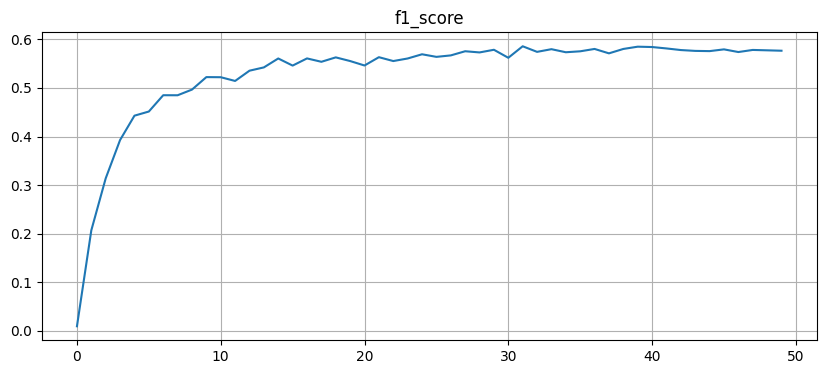

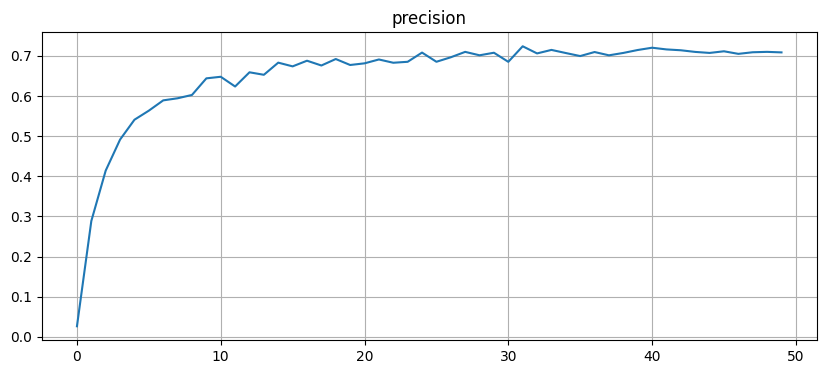

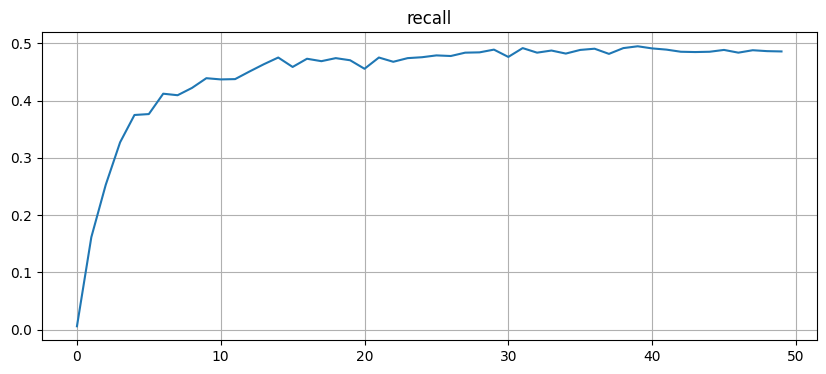

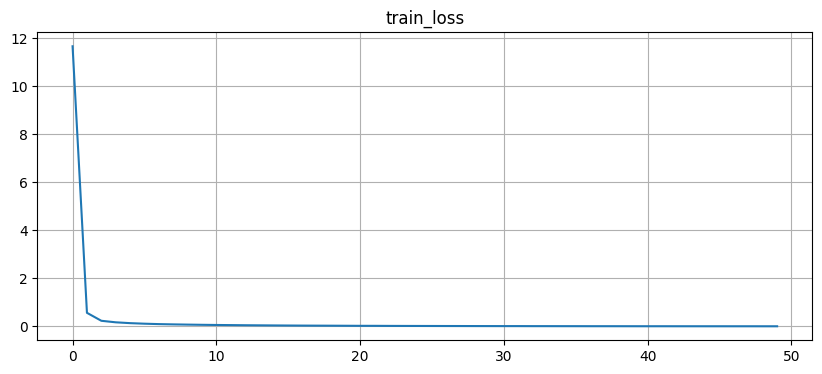

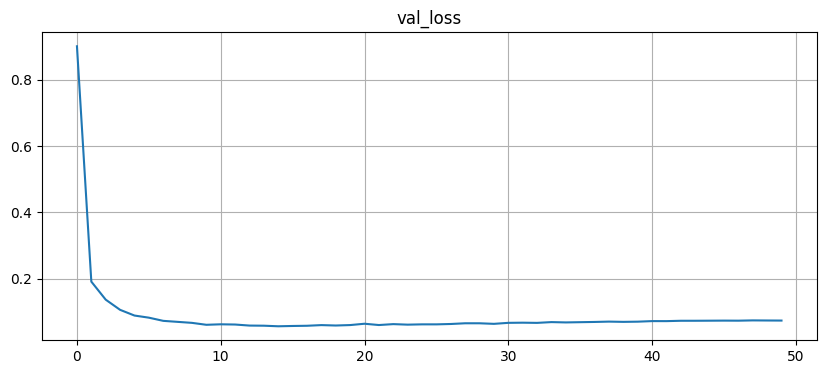

In [24]:
'''plt.figure (figsize = (10, 4))
for i, (name, history) in enumerate (sorted (metrics.items ())):
    plt.subplot (1, len (metrics), i + 1)
    plt.title (name)
    plt.plot (*zip (*history))
    plt.grid ()
plt.show ()'''

for i, (name, history) in enumerate (sorted (metrics.items ())):
    #plt.plot (1, len (metrics), i + 1)
    plt.figure (figsize = (10, 4))
    plt.title (name)
    plt.plot (*zip (*history))
    plt.grid ()
    plt.show ()


In [25]:
model.eval()
with torch.no_grad():
    for batch in test_loader:
        
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        outputs = model (input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        outputs = outputs.logits.argmax(-1)

        #print (outputs)
        print (tokenizer.batch_decode (labels))
        print (tokenizer.batch_decode (outputs))

        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        print (sanity_check (outputs, labels, to_print = True))

        break

['семантики <extra_id_0> термина <extra_id_0> терминоведения <extra_id_0> переводоведения <extra_id_0> лексикографии</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>', 'глобальную оптимизацию <extra_id_0> оптимизацию <extra_id_0> генетического алгоритма <extra_id_0> алгоритма <extra_id_0> эвристик <extra_id_0> размерность задачи</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [26]:


model.eval ()  # Устанавливаем модель в режим оценки
val_preds, val_labels = [], []

with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        val_preds.extend (out)
        val_labels.extend (labels)

    print ('Validation: ', sanity_check (val_preds, val_labels))


val_preds, val_labels = [], []

with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        val_preds.extend (out)
        val_labels.extend (labels)

    print ('Test: ', sanity_check (val_preds, val_labels))

100%|██████████| 105/105 [00:20<00:00,  5.04it/s]


Validation:  (0.7087529047250194, 0.485926712692512, 0.5765595463137997)


100%|██████████| 105/105 [00:19<00:00,  5.26it/s]


Test:  (0.7087872185911401, 0.5464725643896976, 0.6171356307303194)


In [27]:

NUM_BEAMS = 1

val_preds, val_labels = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels.extend (labels)

    print ('Validation wmax: ', sanity_check (val_preds, val_labels))


val_preds, val_labels = [], []
with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels.extend (labels)

    print ('Test wmax: ', sanity_check (val_preds, val_labels))

100%|██████████| 105/105 [00:48<00:00,  2.17it/s]


Validation wmax:  (0.7934272300469484, 0.8077535847052576, 0.8005263157894736)


100%|██████████| 105/105 [00:44<00:00,  2.37it/s]


Test wmax:  (0.7756911841418883, 0.8325867861142218, 0.8031325951930868)


In [28]:
val_preds [0]

tensor([    0,   544, 19868,   657, 20099, 10332,   308, 20099, 10332,   411,
         6335, 20099,  8419,   411,  6335, 20099, 17374,  1040, 17519,     1,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       device='cuda:0')

In [ ]:
#model.save_pretrained('./coint_rut5small_finetune_6171-8031')
#tokenizer.save_pretrained('./coint_rut5small_finetune_6171-8031')

('./coint_rut5small_finetune_6171-8031\\tokenizer_config.json',
 './coint_rut5small_finetune_6171-8031\\special_tokens_map.json',
 './coint_rut5small_finetune_6171-8031\\spiece.model',
 './coint_rut5small_finetune_6171-8031\\added_tokens.json',
 './coint_rut5small_finetune_6171-8031\\tokenizer.json')

In [ ]:
#checkpoint = { 
#    'epoch': 50,
#    'model': model.state_dict(),
#    'optimizer': optimizer.state_dict()}
#torch.save (checkpoint, './coint_rut5small_finetune_6171-8031/checkpoint.pth')